In [1]:
### import necessary libraries
import ee
import geemap
import sklearn
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

ee.Authenticate()
ee.Initialize(project="ee-franciscofurey")

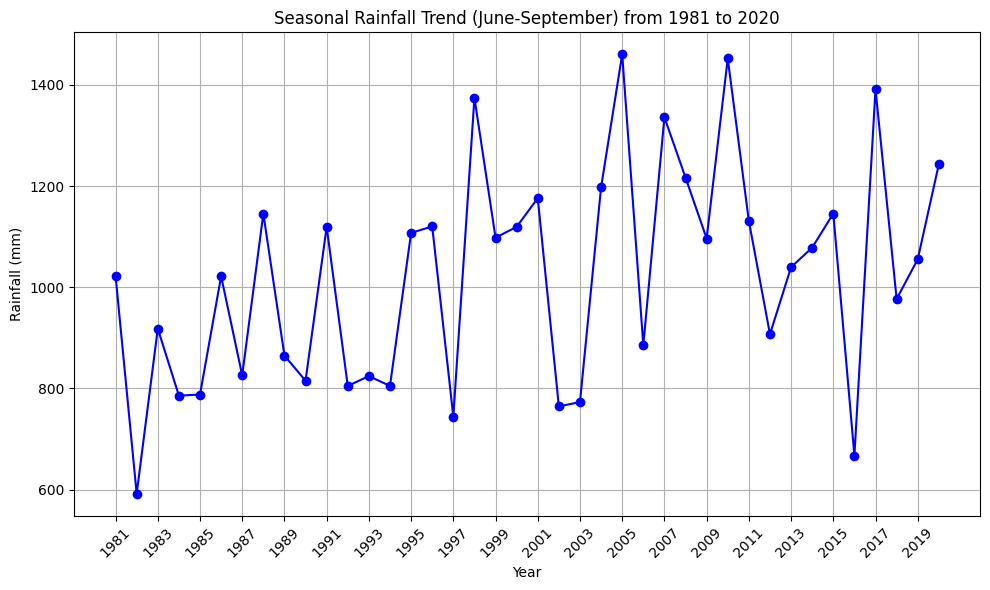

In [24]:
# Define the CHIRPS dataset and the point for which to extract precipitation data.
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
geometry = ee.Geometry.Point([77.58253382230242, 12.942038375108362])

def create_seasonal_image(year):
    """
    For a given year, filters the CHIRPS dataset for the rainy season,
    computes the total rainfall, and sets relevant properties.
    """
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 1)
    season_filtered = chirps.filter(ee.Filter.date(start_date, end_date))
    total = season_filtered.reduce(ee.Reducer.sum())
    return total.set({
        'system:time_start': start_date.millis(),
        'system:time_end': end_date.millis(),
        'year': year,
    })

# Generate a list of years from 1981 to 2020.
years = ee.List.sequence(1981, 2020)

# Map the function over the list of years to create an ImageCollection.
yearly_images = years.map(create_seasonal_image)
yearly_col = ee.ImageCollection.fromImages(yearly_images)

# Function to extract rainfall data for plotting.
def extract_rainfall_data(image):
    """Extracts rainfall data for a given image (year) at the specified geometry."""
    data = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry, scale=5566).getInfo()
    return data['precipitation_sum']

# Extract data for each year.
rainfall_data = [extract_rainfall_data(yearly_col.filter(ee.Filter.eq('year', year)).first()) for year in range(1981, 2021)]

# Plotting with Matplotlib.
plt.figure(figsize=(10, 6))
plt.plot(range(1981, 2021), rainfall_data, marker='o', linestyle='-', color='b')
plt.title('Seasonal Rainfall Trend (June-September) from 1981 to 2020')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.xticks(range(1981, 2021, 2), rotation=45)
plt.tight_layout()
plt.show()


In [25]:
# Fetch the information of the first feature
info = yearly_col.first().getInfo()

# Pretty print the information
print(json.dumps(info, indent=2))

{
  "type": "Image",
  "bands": [
    {
      "id": "precipitation_sum",
      "data_type": {
        "type": "PixelType",
        "precision": "double"
      },
      "crs": "EPSG:4326",
      "crs_transform": [
        1,
        0,
        0,
        0,
        1,
        0
      ]
    }
  ],
  "properties": {
    "system:time_start": 347155200000,
    "year": 1981,
    "system:time_end": 376012800000,
    "system:index": "0"
  }
}


In [26]:
def process_image(image):
    year = image.get('year')
    year_image = ee.Image.constant(year).toShort()
    result_image = ee.Image.cat([year_image, image]).rename(['year', 'precipitation'])
    return result_image

processed_col = yearly_col.map(process_image)

info = processed_col.first().getInfo()

print(processed_col.size().getInfo())
print(processed_col.first().bandNames().getInfo())
print(' ')
print(json.dumps(info, indent=2))

40
['year', 'precipitation']
 
{
  "type": "Image",
  "bands": [
    {
      "id": "year",
      "data_type": {
        "type": "PixelType",
        "precision": "int",
        "min": -32768,
        "max": 32767
      },
      "crs": "EPSG:4326",
      "crs_transform": [
        1,
        0,
        0,
        0,
        1,
        0
      ]
    },
    {
      "id": "precipitation",
      "data_type": {
        "type": "PixelType",
        "precision": "double"
      },
      "crs": "EPSG:4326",
      "crs_transform": [
        1,
        0,
        0,
        0,
        1,
        0
      ]
    }
  ],
  "properties": {
    "system:index": "0"
  }
}


In [27]:
# Calculate Sens Slope
sens = processed_col.reduce(ee.Reducer.sensSlope())

# Directly use 'sens' without calling .first()
info = sens.getInfo()  # This should work assuming 'sens' is an ee.Image
print(json.dumps(info, indent=2))


{
  "type": "Image",
  "bands": [
    {
      "id": "slope",
      "data_type": {
        "type": "PixelType",
        "precision": "double"
      },
      "crs": "EPSG:4326",
      "crs_transform": [
        1,
        0,
        0,
        0,
        1,
        0
      ]
    },
    {
      "id": "offset",
      "data_type": {
        "type": "PixelType",
        "precision": "double"
      },
      "crs": "EPSG:4326",
      "crs_transform": [
        1,
        0,
        0,
        0,
        1,
        0
      ]
    }
  ]
}


In [28]:
# Assuming 'sens' has a band named 'slope' you want to visualize
sens_slope = sens.select('slope')  # Adjust 'slope' to the correct band name if different

# Visualization parameters remain the same
vis_params = {
    'min': -10, 
    'max': 10,
    'palette': ['brown', 'white', 'blue']
}

# Use the correctly selected single-band image for visualization
Map = geemap.Map()
Map.addLayer(yearly_col, {}, 'Collection', False)
Map.addLayer(sens_slope, vis_params, 'Sens Slope')
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…